In [80]:
import pandas as pd
import datetime
import math
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 10))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

In [3]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 31)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


In [4]:
df.shape

(2433, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2433 entries, 2009-12-31 to 2019-08-30
Data columns (total 6 columns):
High         2433 non-null float64
Low          2433 non-null float64
Open         2433 non-null float64
Close        2433 non-null float64
Volume       2433 non-null float64
Adj Close    2433 non-null float64
dtypes: float64(6)
memory usage: 133.1 KB


In [9]:
df['Adj Close'].describe()

count    2433.000000
mean       99.371847
std        51.917441
min        23.943514
25%        56.432617
50%        90.638489
75%       136.288544
max       228.523819
Name: Adj Close, dtype: float64

In [10]:
moving_avg = df['Adj Close'].rolling(window=100).mean()

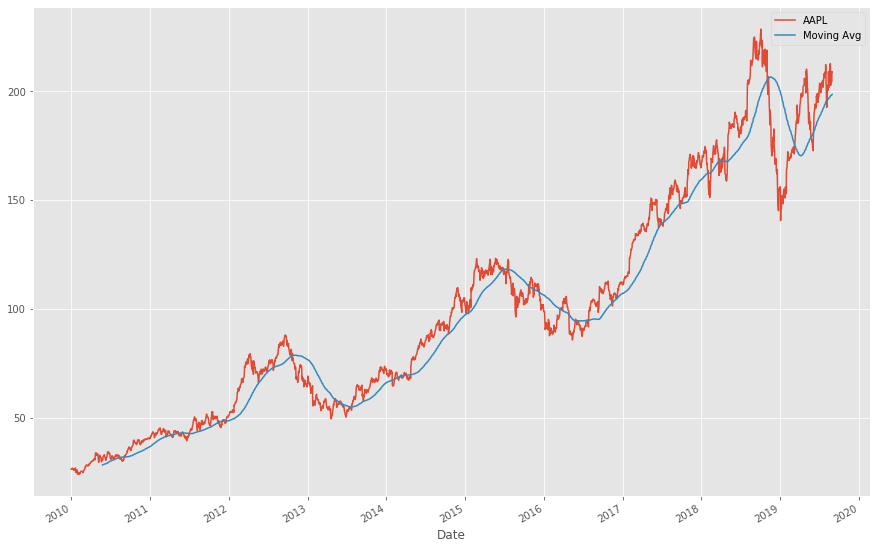

In [17]:
df['Adj Close'].plot(label='AAPL')
moving_avg.plot(label='Moving Avg')
plt.legend()

In [74]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [75]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-12-31,26.272409,88102700.0,1.323968,-1.126074
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538


In [70]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
Y = y[:-forecast_out]
Y_lately = y[-forecast_out:]

In [71]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2019-08-26,206.490005,26043600.0,1.031529,0.306036,NaN
2019-08-27,204.160004,25873300.0,2.458858,-1.780043,NaN
2019-08-28,205.529999,15938800.0,1.167710,0.700633,NaN
2019-08-29,209.009995,20990500.0,1.272668,0.244602,NaN
2019-08-30,208.740005,21143400.0,1.556961,-0.675675,NaN


In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [82]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [83]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [84]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [85]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [86]:
confidencereg = clfreg.score(X_test, Y_test)
confidencepoly2 = clfpoly2.score(X_test, Y_test)
confidencepoly3 = clfpoly3.score(X_test, Y_test)
confidenceknn = clfknn.score(X_test, Y_test)

In [87]:
confidencereg 

0.9685038499498774

In [88]:
confidencepoly2

0.969482233095528

In [89]:
confidencepoly3

0.9695889726319139

In [90]:
confidenceknn

0.9547801520978476

In [91]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan

In [96]:
dfreg.tail(26)

,Adj Close,Volume,HL_PCT,PCT_change,Forecast
Date,,,,,
2019-08-30,208.740005,21143400.0,1.556961,-0.675675,NaN
2019-08-31,NaN,NaN,NaN,NaN,205.724982
2019-09-01,NaN,NaN,NaN,NaN,201.859878
2019-09-02,NaN,NaN,NaN,NaN,180.860174
2019-09-03,NaN,NaN,NaN,NaN,187.628572
2019-09-04,NaN,NaN,NaN,NaN,195.513169
2019-09-05,NaN,NaN,NaN,NaN,185.621621
2019-09-06,NaN,NaN,NaN,NaN,191.476804
2019-09-07,NaN,NaN,NaN,NaN,190.856063


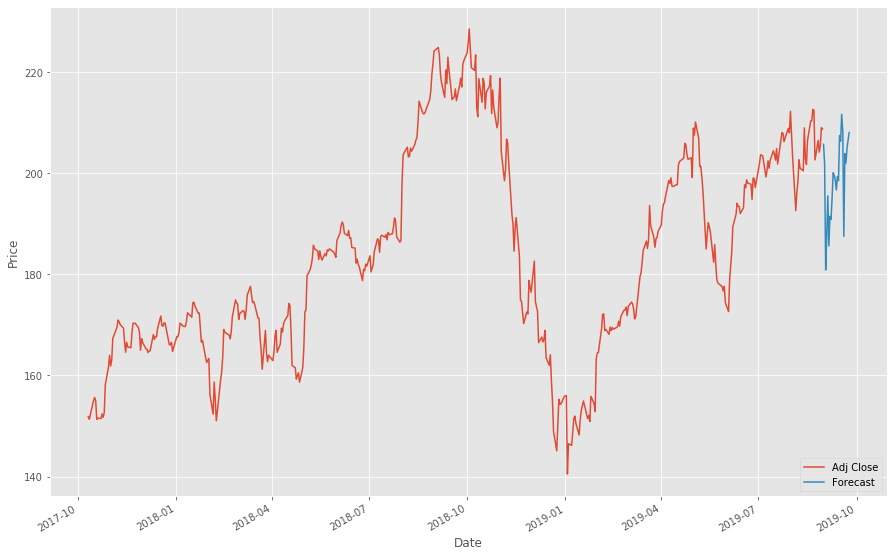

In [92]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()